In [1]:
# House Price Prediction with Hyperparameter Tuning - Simplified

# 1. Imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [3]:
# 2. Load data (replace with your file path)
df = pd.read_csv('kc_house_data.csv')

In [4]:
# 3. Prepare data
print(f"Dataset: {df.shape[0]} samples, {df.shape[1]} features")
print(df.isnull().sum())  # Check missing values

Dataset: 21613 samples, 21 features
id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64


In [5]:
X = df.drop(['id', 'price', 'date'], axis=1)
y = df['price']


In [6]:
# 4. Identify variable types
categorical_columns = selector(dtype_include=object)(X)
num_vars = [var for var in X.columns if var not in categorical_columns]
categorical_vars = [var for var in num_vars if len(X[var].unique()) <= 20]
cont_vars = [var for var in num_vars if var not in categorical_vars]

print(f"Categorical vars: {categorical_vars}")
print(f"Continuous vars: {cont_vars}")


Categorical vars: ['bedrooms', 'floors', 'waterfront', 'view', 'condition', 'grade']
Continuous vars: ['bathrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15']


In [7]:
# 5. Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
print(X_train.shape, X_test.shape)


(15129, 18) (6484, 18)


In [8]:
# 6. Log transform target (skewed)
y_train_log = np.log(y_train)
y_test_log = np.log(y_test)


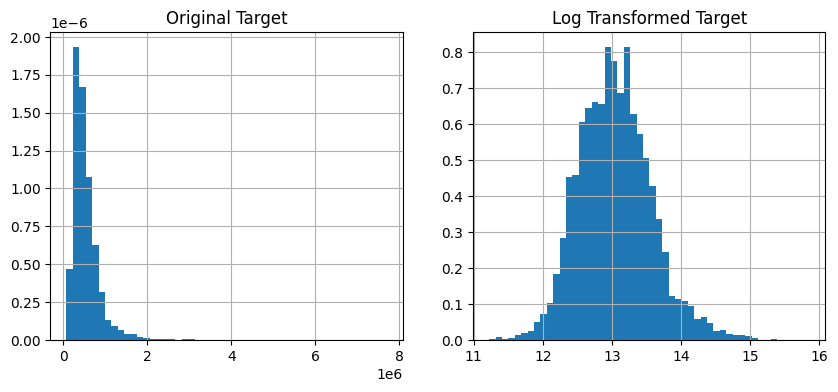

In [9]:
# Visualize target distribution
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
y.hist(bins=50, density=True)
plt.title('Original Target')
plt.subplot(1, 2, 2)
pd.Series(y_train_log).hist(bins=50, density=True)
plt.title('Log Transformed Target')
plt.show()


In [10]:
# 7. Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('one-hot-encoder', OneHotEncoder(handle_unknown='ignore'), categorical_vars),
        ('standard_scaler', StandardScaler(), cont_vars)
    ])


In [11]:
# 8. Create full pipeline
model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])


In [12]:
# 9. Baseline model
model.fit(X_train, y_train_log)
y_pred_log = model.predict(X_test)
y_pred = np.exp(y_pred_log)

rmse_baseline = np.sqrt(mean_squared_error(y_test, y_pred))
mae_baseline = mean_absolute_error(y_test, y_pred)
print(f"Baseline RMSE: {rmse_baseline:.2f}")
print(f"Baseline MAE: {mae_baseline:.2f}")


Baseline RMSE: 135480.45
Baseline MAE: 69533.04


In [13]:
# 10. Hyperparameter tuning - RandomizedSearchCV
param_dist = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__max_depth': [10, 20, None],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4]
}

random_search = RandomizedSearchCV(
    model, param_distributions=param_dist, n_iter=20, 
    cv=5, scoring='neg_mean_squared_error', random_state=42, n_jobs=-1
)

random_search.fit(X_train, y_train_log)
print("Best params (Randomized):", random_search.best_params_)


Best params (Randomized): {'regressor__n_estimators': 300, 'regressor__min_samples_split': 10, 'regressor__min_samples_leaf': 1, 'regressor__max_depth': 20}


In [14]:
# 11. Best model predictions
best_random = random_search.best_estimator_
y_pred_log_rs = best_random.predict(X_test)
y_pred_rs = np.exp(y_pred_log_rs)

rmse_rs = np.sqrt(mean_squared_error(y_test, y_pred_rs))
mae_rs = mean_absolute_error(y_test, y_pred_rs)
print(f"RandomizedSearch RMSE: {rmse_rs:.2f} (improvement: {((rmse_baseline - rmse_rs)/rmse_baseline)*100:.1f}%)")
print(f"RandomizedSearch MAE: {mae_rs:.2f}")


RandomizedSearch RMSE: 138733.06 (improvement: -2.4%)
RandomizedSearch MAE: 69807.27


In [15]:
# 12. GridSearchCV (fine-tune around best params)
param_grid = {
    'regressor__n_estimators': [200, 250, 300],
    'regressor__max_depth': [15, 20, 25],
    'regressor__min_samples_split': [2, 4],
    'regressor__min_samples_leaf': [1, 2]
}

grid_search = GridSearchCV(
    best_random, param_grid, cv=5, 
    scoring='neg_mean_squared_error', n_jobs=-1
)

grid_search.fit(X_train, y_train_log)
print("Best params (Grid):", grid_search.best_params_)


Best params (Grid): {'regressor__max_depth': 20, 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 4, 'regressor__n_estimators': 300}


In [17]:
# 13. Final model results
best_model = grid_search.best_estimator_
y_pred_log_final = best_model.predict(X_test)
y_pred_final = np.exp(y_pred_log_final)

rmse_final = np.sqrt(mean_squared_error(y_test, y_pred_final))
mae_final = mean_absolute_error(y_test, y_pred_final)
print(f"Final RMSE: {rmse_final:.2f}")
print(f"Final MAE: {mae_final:.2f}")
print(f"Overall improvement: {((rmse_baseline - rmse_final)/rmse_baseline)*100:.1f}%")

Final RMSE: 136644.58
Final MAE: 69339.58
Overall improvement: -0.9%
